<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Utils" data-toc-modified-id="Utils-1">Utils</a></span></li><li><span><a href="#Comparaison-entre-algorithmes" data-toc-modified-id="Comparaison-entre-algorithmes-2">Comparaison entre algorithmes</a></span><ul class="toc-item"><li><span><a href="#Création-d'un-unique-dataframe" data-toc-modified-id="Création-d'un-unique-dataframe-2.1">Création d'un unique dataframe</a></span></li><li><span><a href="#Affichage" data-toc-modified-id="Affichage-2.2">Affichage</a></span></li><li><span><a href="#Temps-d'inférence" data-toc-modified-id="Temps-d'inférence-2.3">Temps d'inférence</a></span></li></ul></li><li><span><a href="#Comparaison-pour-des-qualités-d'images-différentes" data-toc-modified-id="Comparaison-pour-des-qualités-d'images-différentes-3">Comparaison pour des qualités d'images différentes</a></span><ul class="toc-item"><li><span><a href="#Unique-dataframe" data-toc-modified-id="Unique-dataframe-3.1">Unique dataframe</a></span></li><li><span><a href="#Affichage" data-toc-modified-id="Affichage-3.2">Affichage</a></span></li></ul></li><li><span><a href="#Temps-d'inférence-pour-différentes-qualités-d'images" data-toc-modified-id="Temps-d'inférence-pour-différentes-qualités-d'images-4">Temps d'inférence pour différentes qualités d'images</a></span></li></ul></div>

Ce notebook sert à afficher des graphiques qui résument les outputs de l'inférence sur `Parcours_1` avec les différents algorithmes.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
#sns.set()

# Utils

In [2]:
def import_outputs(path, panoptic=False):
    df = pd.read_json(path, orient='index')
    df.index = df.index.astype(int)
    if panoptic:
        df['pred_classes'] = df.apply(lambda row: [elem['category_id'] for elem in row if elem is not None], axis=1)
        df = df.filter(['pred_classes'])
    else:
        df.drop('scores', axis=1, inplace=True)
    return df

In [3]:
def count_classes(preds, name, label_max=80):
    counts = {k: 0 for k in range(label_max)}
    for _, pred in preds.iteritems():
        for p in pred:
            counts[p] += 1
    return pd.DataFrame.from_dict(counts, orient='index', columns=[name])

Labels :

In [4]:
from pycocotools.coco import COCO
dataDir = '/Users/Benjamin/Documents/INFO/R&D/Projet/coco'
dataType = 'val2017'
annFile = '{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco = COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
labels = [cat['name'] for cat in cats]
labels[:5]

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


['person', 'bicycle', 'car', 'motorcycle', 'airplane']

# Comparaison entre algorithmes

In [6]:
faster = import_outputs('/Users/Benjamin/Documents/INFO/R&D/Projet/outputs_parcours_1/outputs_fasterrcnn.json')
mask = import_outputs('/Users/Benjamin/Documents/INFO/R&D/Projet/outputs_parcours_1/outputs_maskrcnn.json')
panoptic = import_outputs('/Users/Benjamin/Documents/INFO/R&D/Projet/outputs_parcours_1/outputs_panopticfpn.json', True)

## Création d'un unique dataframe

In [7]:
classes = pd.concat([faster['pred_classes'].rename('faster'),
                     mask['pred_classes'].rename('mask'), 
                     panoptic['pred_classes'].rename('panoptic')], axis=1)

In [8]:
counts = pd.concat([count_classes(faster['pred_classes'], 'faster'),
                    count_classes(mask['pred_classes'], 'mask'),
                    count_classes(panoptic['pred_classes'], 'panoptic')], axis=1)
counts.index = labels
# counts = counts.iloc[np.argsort(-counts.sum(axis=1)), :]  # sort the dataframe
counts = counts.iloc[np.argsort(-counts['faster']), :]  # sort the dataframe
counts.head()

,faster,mask,panoptic
car,1331,1364,1274
bicycle,1095,1186,937
person,507,493,447
bench,296,283,312
chair,189,185,206


## Affichage

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


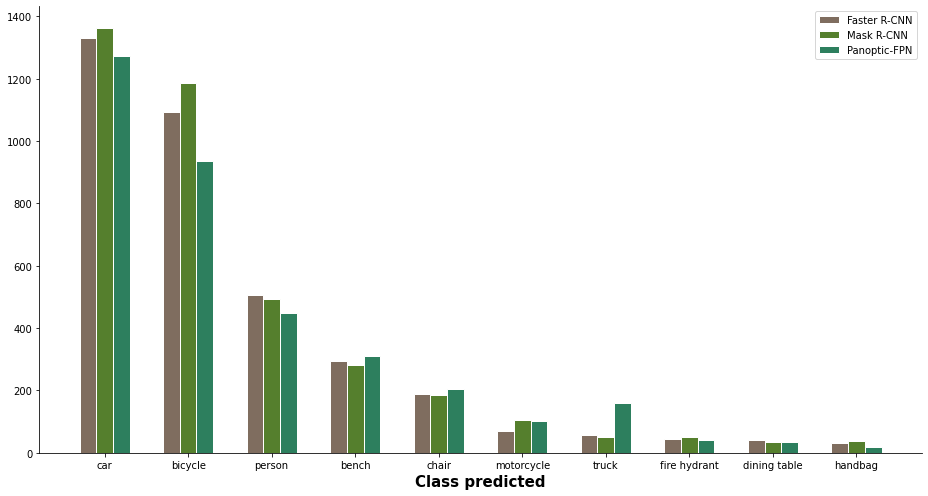

In [12]:
lim = 10
barWidth = 0.2

fig = plt.figure(figsize=(lim+3,7))
ax = plt.gca()
 
# Set position of bar on X axis
x1 = np.arange(lim)
x2 = [x + barWidth for x in x1]
x3 = [x + barWidth for x in x2]
 
# Make the plot
ax.bar(x1, counts[:lim]['faster'], color='#7f6d5f', width=barWidth, edgecolor='white', label='Faster R-CNN')
ax.bar(x2, counts[:lim]['mask'], color='#557f2d', width=barWidth, edgecolor='white', label='Mask R-CNN')
ax.bar(x3, counts[:lim]['panoptic'], color='#2d7f5e', width=barWidth, edgecolor='white', label='Panoptic-FPN')
 
# Add xticks on the middle of the group bars
ax.set_xlabel('Class predicted', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(lim)], counts.index[:lim].to_numpy())

# Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
 
# Create legend & Show graphic
ax.legend()
#ax.set_title('Nombre de prédictions pour chaque classe par algorithme')
fig.tight_layout()
fig.show()
fig.savefig('/Users/Benjamin/Documents/INFO/R&D/Projet/images_rapport/temps_inference_multi_algo.png', dpi=400)

## Temps d'inférence

# Comparaison pour des qualités d'images différentes

## Unique dataframe

In [10]:
list_counts = []
resolutions = ['270p', '540p', '810p', 'default']
data_path = '/Users/Benjamin/Documents/INFO/R&D/Projet/panoptic_fpn/'
for resolution in resolutions:
    df = import_outputs(data_path + f'Parcours_1_1hz_{resolution}/outputs.json', True)
    list_counts.append(count_classes(df['pred_classes'], resolution))
counts = pd.concat(list_counts, axis=1)
counts.index = labels
counts = counts.iloc[np.argsort(-counts['default']), :]  # sort the dataframe
counts.head()

,270p,540p,810p,default
car,691,1058,1218,1586
bicycle,468,712,852,1149
person,162,292,398,597
wine glass,301,347,372,379
broccoli,401,386,379,373


## Affichage

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


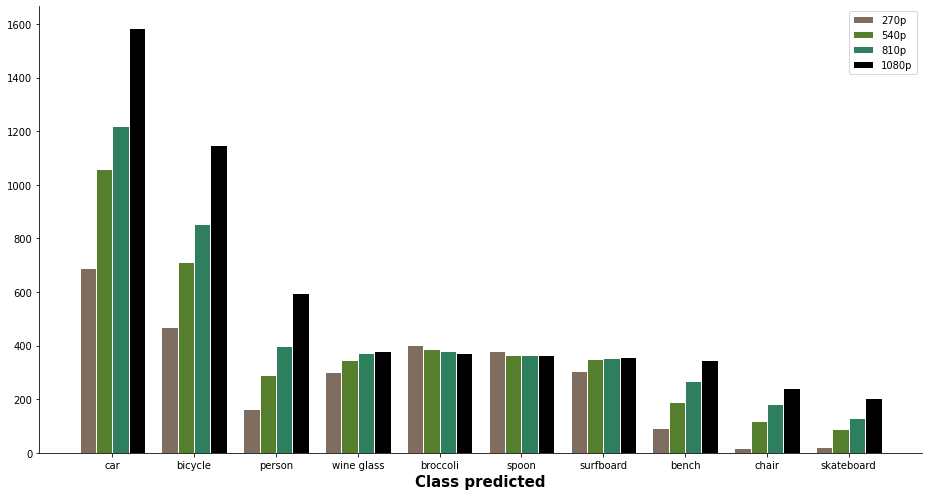

In [61]:
lim = 10
barWidth = 0.2

fig = plt.figure(figsize=(lim+3,7))
ax = plt.gca()
 
# Set position of bar on X axis
x1 = range(lim)
x2 = [x + barWidth for x in x1]
x3 = [x + barWidth for x in x2]
x4 = [x + barWidth for x in x3]
xticks = [(xx2 + xx3)/2 for xx2, xx3 in zip(x2, x3)]

# Make the plot
ax.bar(x1, counts[:lim]['270p'], color='#7f6d5f', width=barWidth, edgecolor='white', label='270p')
ax.bar(x2, counts[:lim]['540p'], color='#557f2d', width=barWidth, edgecolor='white', label='540p')
ax.bar(x3, counts[:lim]['810p'], color='#2d7f5e', width=barWidth, edgecolor='white', label='810p')
ax.bar(x4, counts[:lim]['default'], color='k', width=barWidth, edgecolor='white', label='1080p')
 
# Add xticks on the middle of the group bars
ax.set_xlabel('Class predicted', fontweight='bold', fontsize=15)
plt.xticks(xticks, counts.index[:lim].to_numpy())

# Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
 
# Create legend & Show graphic
ax.legend()
#ax.set_title('Nombre de prédictions pour chaque classe pour différentes résolutions')
fig.tight_layout()
fig.show()
fig.savefig('/Users/Benjamin/Documents/INFO/R&D/Projet/images_rapport/classes_predites_resolution.png', dpi=400)

# Temps d'inférence pour différentes qualités d'images

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


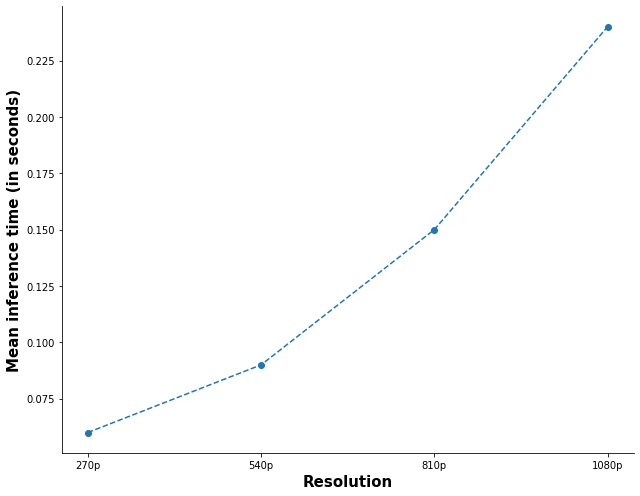

In [63]:
resolutions = ['270p', '540p', '810p', '1080p']
times = [0.06, 0.09, 0.15, 0.24]

fig = plt.figure(figsize=(9,7))
ax = plt.gca()
ax.plot(resolutions, times, linestyle='--')
ax.scatter(resolutions, times)

# Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Resolution', fontweight='bold', fontsize=15)
ax.set_ylabel('Mean inference time (in seconds)', fontweight='bold', fontsize=15)

fig.tight_layout()
fig.show()
fig.savefig('/Users/Benjamin/Documents/INFO/R&D/Projet/images_rapport/temps_inference_resolution_panoptic.png', dpi=400)